C:\Users\SANDY\AppData\Local\Temp\ipykernel_10148\4069740368.py:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  I = I.resize(size, Image.ANTIALIAS)


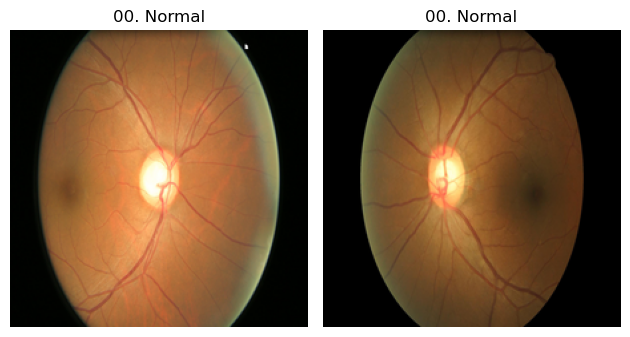

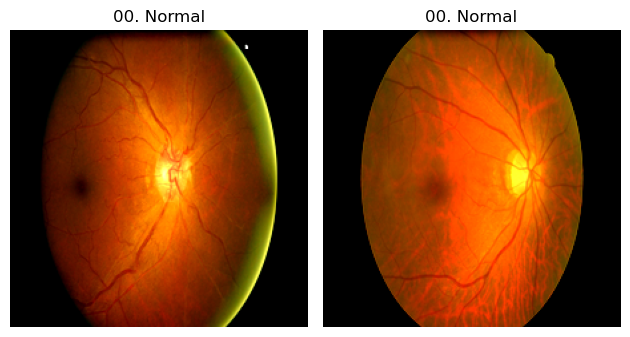

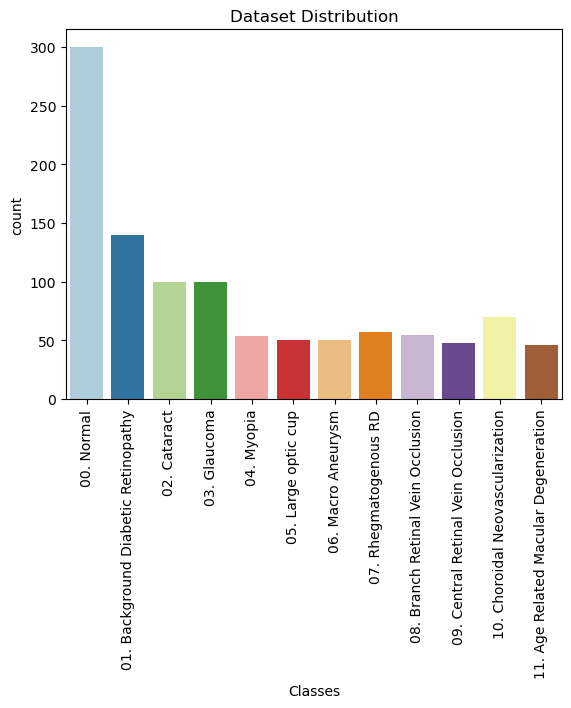

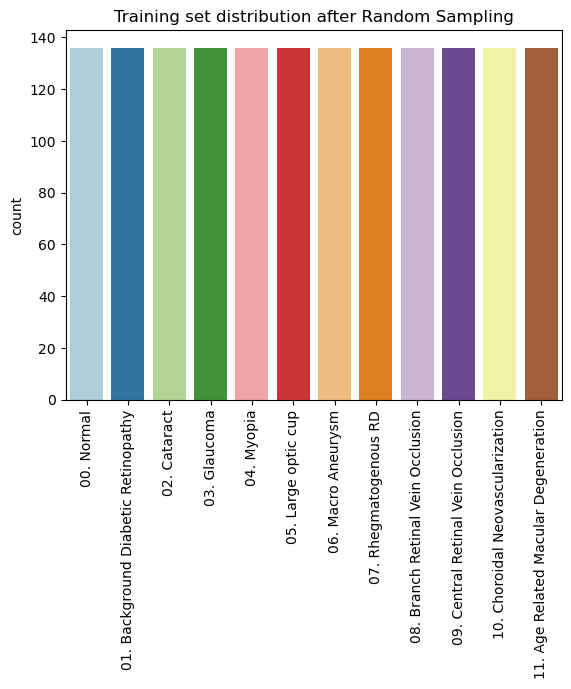

Number of training examples = 1632
Number of validation examples = 263
Number of test examples = 321
X_train shape: (1632, 224, 224, 3)
Y_train shape: (1632, 12)
X_val shape: (263, 224, 224, 3)
Y_val shape: (263, 12)
X_test shape: (321, 224, 224, 3)
Y_test shape: (321, 12)
Epoch 1/30
51/51 [==============================] - 275s 5s/step - loss: 8.7141 - accuracy: 0.3879 - val_loss: 6.4300 - val_accuracy: 0.3384
Epoch 2/30
51/51 [==============================] - 255s 5s/step - loss: 5.6147 - accuracy: 0.5423 - val_loss: 7.2376 - val_accuracy: 0.5894
Epoch 3/30
51/51 [==============================] - 258s 5s/step - loss: 4.7893 - accuracy: 0.6520 - val_loss: 5.2849 - val_accuracy: 0.4563
Epoch 4/30
51/51 [==============================] - 259s 5s/step - loss: 3.2733 - accuracy: 0.6991 - val_loss: 5.8226 - val_accuracy: 0.5551
Epoch 5/30
51/51 [==============================] - 263s 5s/step - loss: 4.2144 - accuracy: 0.6716 - val_loss: 7.8011 - val_accuracy: 0.4411
Epoch 6/30
51/51 [===

In [21]:
import cv2
import random
import numpy as np
import pandas as pd

import seaborn as sns
from PIL import Image
from keras import regularizers
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import models
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os

def Dataset(folder_path):
    image_files = []
    labels = []
    
    # List all files in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):  # Add other image extensions if needed
                image_files.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Assuming folder names are the labels
        
    data = pd.DataFrame({'Images': image_files, 'Classes': labels})
    
    # Read and resize the images
    X = []
    size = (224, 224)  # Image size (width, height)

    for image_path in data['Images']:
        try:
            I = Image.open(image_path)
            I = I.resize(size, Image.ANTIALIAS)
            X.append(I)
        except Exception as e:
            print(f"Error opening image {image_path}: {str(e)}")

    # Pack image arrays into the dataframe
    data['Images'] = X

    # Convert string Class labels to numeric
    en = LabelEncoder()
    data['Labels'] = en.fit_transform(data['Classes'].values)

    return data

# Import data from a folder
df = Dataset("F:\Projects\eye!!!\modified_dataset - Copy")  # Replace with the actual folder path

# Now you can use 'df' which contains your dataset with images and labels


import matplotlib.pyplot as plt

# Display random examples
fig = plt.figure()
for i in range(1,3):
    random.seed(i)
    ax = fig.add_subplot(1,2,i)
    ax.imshow(df['Images'][random.randint(1,len(df))])
    ax.set_title(df['Classes'][random.randint(1,len(df))])
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Define a function to enhance contrast of fundus images
def enhance_contrast(img, contrast):
    alpha_c = 131 * (contrast + 127) / (127 * (131 - contrast))
    gamma_c = 127 * (1 - alpha_c)
    enhanced_img = cv2.addWeighted(img, alpha_c, img, 0, gamma_c)
    return enhanced_img

def preprocess_image(img, contrast=40, target_size=(224, 224)):
    # Enhance image contrast
    img = enhance_contrast(img, contrast)
    
    # Resize the image to the target size
    img = cv2.resize(img, dsize=target_size)
    
    return img

# Define a function to apply preprocessing to a DataFrame
def preprocess_dataframe(df, contrast=40,):
    df['Images'] = [preprocess_image(np.array(img), contrast=contrast) for img in df['Images']]
    return df

# Load your dataset
# Assuming df contains your dataset with columns 'Images', 'Classes', and 'Labels'

# Apply image processing
df = preprocess_dataframe(df)

# Display random examples after preprocessing
fig = plt.figure()
for i in range(1, 3):
    random.seed(i)
    index = random.randint(0, len(df) - 1)
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(df['Images'][index], cmap='gray')
    ax.set_title(df['Classes'][index])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Define a function to visualize number of fundus images available per class
def class_distribution(df):
    p = sns.countplot(x="Classes", data=df, palette='Paired')
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    plt.title('Dataset Distribution')
    plt.show()
    
    return

# Visualize dataset distribution
class_distribution(df)

# Create function to split dataset into Training and Validation set
def split_dataset(df, testSize):
    
    X = df['Images'].tolist()
    y = df['Labels'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size = testSize, 
                                                        random_state = 394, 
                                                        shuffle = True, 
                                                        stratify = y)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size = testSize + 0.05, 
                                                      random_state = 394, 
                                                      shuffle = True, 
                                                      stratify = y_train)
    
    # Define a function to balance training set
    def balance_data(X, y):
        # Get number of samples in majority class
        class_size = max(Counter(y).values())
        df = pd.DataFrame({'Images': X, 'Labels': y})

        balanced_df = df.groupby(['Labels']).apply(
            lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
        balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

        X = balanced_df['Images'].tolist()
        y = balanced_df['Labels'].tolist()

        return X, y

    # Resample the images in training set
    X_train, y_train = balance_data(X_train, y_train)
    
    # Transform images to numpy arrays
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    
    # Transform Labels to categorical numpy arrays
    y_train = to_categorical(y_train, num_classes = max(y_train)+1, dtype = 'int')
    y_val = to_categorical(y_val, num_classes = max(y_val)+1, dtype = 'int')
    y_test = to_categorical(y_test, num_classes = max(y_test)+1, dtype = 'int')
    
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# Split dataset into Training and Test set
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(df, testSize=0.3)

p = sns.countplot(x = np.argmax(y_train, axis=1), palette='Paired')
p.set_xticklabels(np.unique(df['Classes']), rotation=90)
plt.title('Training set distribution after Random Sampling')
plt.show()

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

train_datagen = ImageDataGenerator(horizontal_flip = False,
                                 vertical_flip = False,
                                 zoom_range = 0,
                                 rotation_range = 0,
                                 width_shift_range = 1,
                                 height_shift_range = 1,
                                 shear_range = 0.01,
                                 fill_mode="nearest")

from tensorflow import keras

base_model = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=(224,224,3))

base_model.trainable = False

base = base_model.layers[-1].output
gap_layer = keras.layers.GlobalAveragePooling2D()(base)
output = keras.layers.Dense(12, activation= 'softmax')(gap_layer)

new_model =  keras.models.Model(inputs=base_model.input, outputs = output)
# new_model.summary()

optim = keras.optimizers.SGD(learning_rate = 0.001,momentum =0.9)
new_model.compile(optimizer=optim,loss='categorical_crossentropy', metrics = ['accuracy'])

from datetime import datetime
from keras.callbacks import ModelCheckpoint

start_time = datetime.now()

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = new_model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=30, callbacks=[checkpoint])

end_time = datetime.now()
print('time_taken :',end_time-start_time)


In [23]:
score_train = new_model.evaluate(X_train, y_train, verbose=1)
score_val = new_model.evaluate(X_val, y_val, verbose=1)
score_test = new_model.evaluate(X_test, y_test, verbose=1)

print('Training Loss: ' +"{:.3f}".format(score_train[0]))
print('Training Accuracy: ' +"{:.3f}".format(score_train[1]*100) + '%')
print('Validation Loss: ' +"{:.3f}".format(score_val[0]))
print('Validation Accuracy: ' +"{:.3f}".format(score_val[1]*100) + '%')
print('Test Loss: ' +"{:.3f}".format(score_test[0]))
print('Test Accuracy: ' +"{:.3f}".format(score_test[1]*100) + '%')

11/11 [==============================] - 44s 4s/step - loss: 4.0284 - accuracy: 0.6355
Training Loss: 0.231
Training Accuracy: 92.525%
Validation Loss: 5.265
Validation Accuracy: 65.779%
Test Loss: 4.028
Test Accuracy: 63.551%


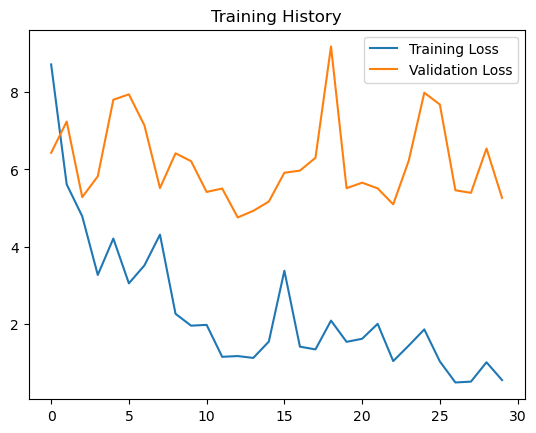

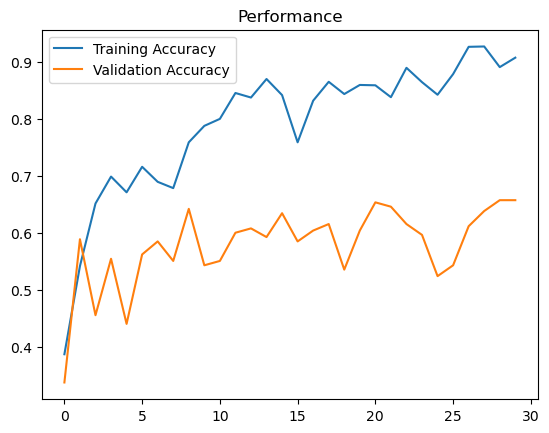

In [25]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.title('Training History')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
# plt.
plt.title('Performance')
plt.legend()
plt.show()

11/11 [==============================] - 53s 4s/step
Test Accuracy: 63.55%
Precision: 0.65
Recall: 0.64
F1 Score: 0.63


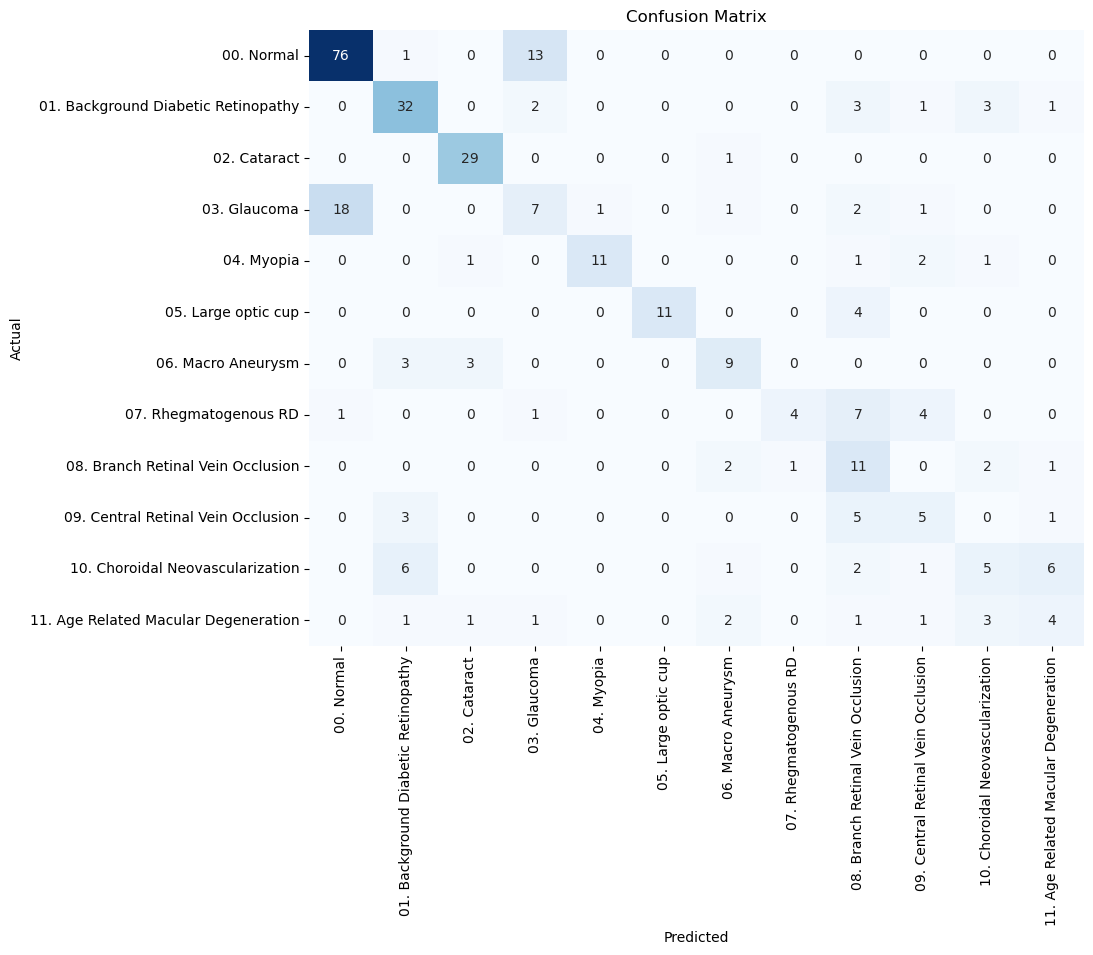

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# ...

def Evaluation(y_true, y_pred, labels, classes):
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)

    # Compute confusion matrix
    CM = confusion_matrix(y_true, y_pred)

    # Calculate additional metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print metrics
    print('Test Accuracy: {:.2f}%'.format(accuracy * 100))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 Score: {:.2f}'.format(f1))

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(CM, index=classes, columns=classes)

    # Display confusion matrix as a table
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, precision, recall, f1, cm_df

# ...

# Test and evaluate the model
y_pred = new_model.predict(X_test, verbose=1)
base = np.unique(df['Classes'].values)
labels = np.unique(df['Labels'].values)
Accuracy, Precision, Recall, F1, Confusion_Matrix = Evaluation(y_test, y_pred, labels, base)


11/11 [==============================] - 45s 4s/step


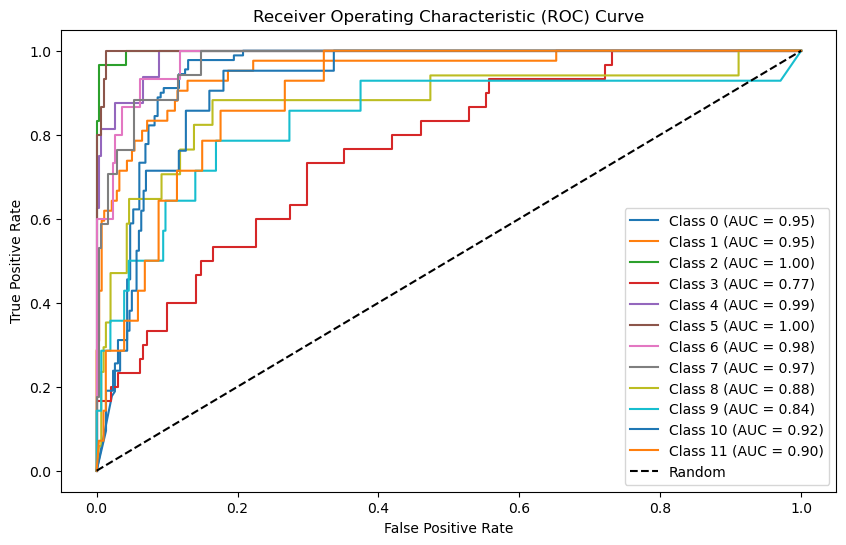

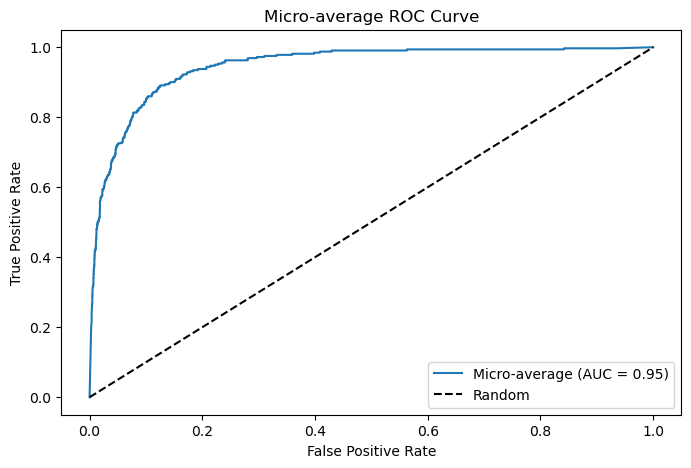

Test Loss: 4.028
Test Accuracy: 63.551%


In [28]:
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
y_pred_proba = new_model.predict(X_test, verbose=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(base)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr_micro, tpr_micro, label='Micro-average (AUC = {:.2f})'.format(roc_auc_micro))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend()
plt.show()

# ...

# Print test loss and accuracy
print('Test Loss: {:.3f}'.format(score_test[0]))
print('Test Accuracy: {:.3f}'.format(score_test[1] * 100) + '%')

1/1 [==============================] - 0s 266ms/step


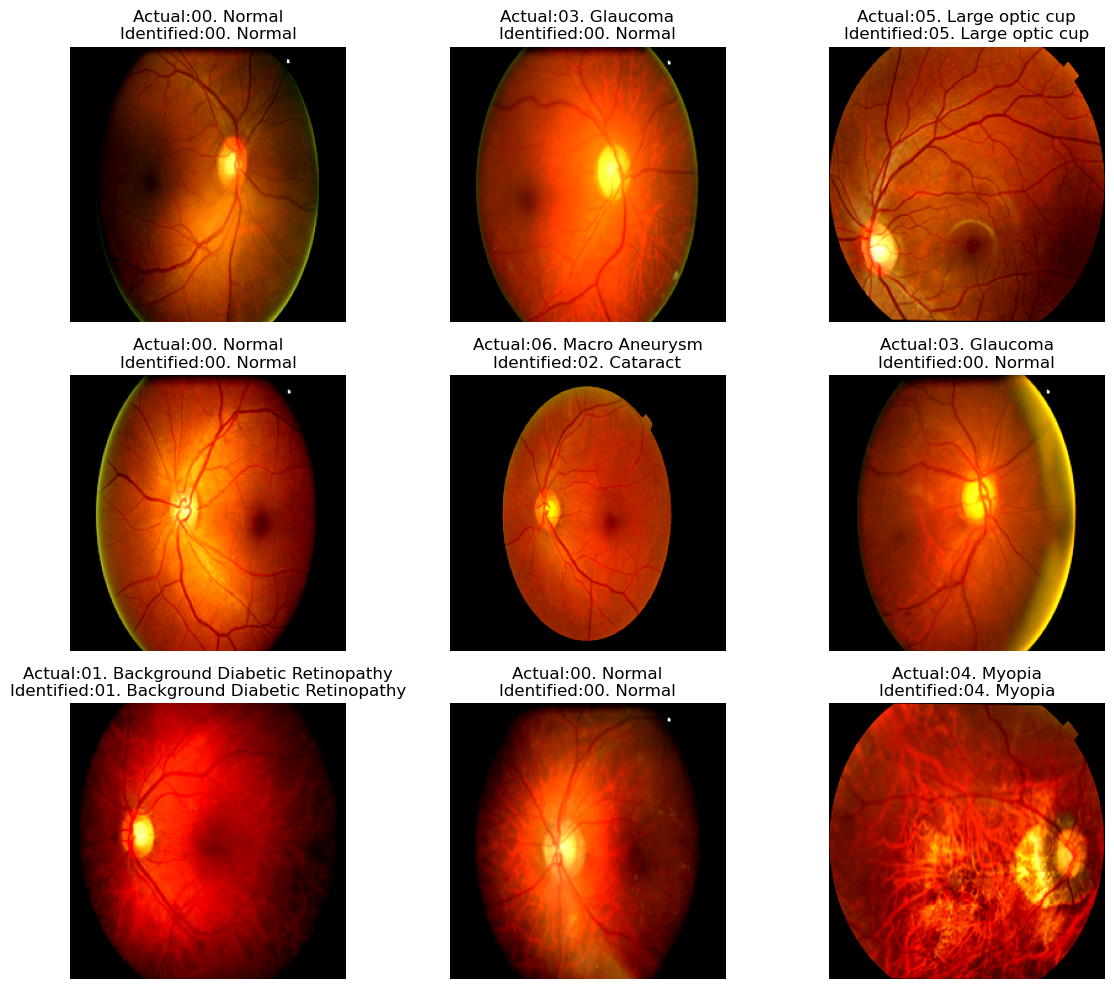

In [30]:
def Predictor(Model, Test_sample, Output, classes):
   
    y = Model.predict(np.expand_dims(Test_sample, axis=0), verbose = 1)
    pred = classes[np.argmax(y)]
    true = classes[np.argmax(Output)]
    
    return pred, true

fig = plt.figure(figsize = (12, 10))
for i in range(1,10):
    ax = fig.add_subplot(3,3,i)
    pred, true = Predictor(new_model, X_test[i], y_test[i], base)
    ax.imshow(X_test[i])
    ax.set_title('Actual:'+ true + '\n' + 'Identified:'+ pred)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [32]:
new_model.save('ocularidentify1.h5')